In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

## Datasets:

In [2]:
class CustomDataset(Dataset):
    def __init__(self,image_dir,label_dir,transforms = None):
        super().__init__()
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transforms
        self.all_image_name = sorted(os.listdir(image_dir), key=lambda x: int(os.path.splitext(x)[0]))
        self.all_label_name = os.listdir(label_dir)
        
    def __len__(self):
        return len(self.all_image_name)
    
    def class_to_idx(self):
        return {
            1:"ODD",
            0:"EVEN"
        }
    
    def __getitem__(self,index):
        
        # image:
        image_filename = self.all_image_name[index]
        image__path = os.path.join(self.image_dir,image_filename)
        image = Image.open(image__path)
        
        # transform:
        if self.transform:
            image = self.transform(image)
        
        # Label:
        label_filename = self.all_label_name[0]
        label_path = os.path.join(self.label_dir,label_filename)
        label_df = pd.read_csv(label_path,header=None)
        #print(label_df.head())
        label = label_df.iloc[index][0]
        #print(label_df.head())
        
        if label == "ODD":
            label = 1.0
        elif label == "EVEN":
            label = 0.0
            
        #label = torch.tensor([label,abs(1-label)])
        
        return image,label

### Directory:

In [3]:
#train :
train_image_dir = r"C:\Users\rahul\python\Machine learning\IITK\Assingment 2\assn2\train\Images\train_images"
train_label_dir = r"C:\Users\rahul\python\Machine learning\IITK\Assingment 2\assn2\train\labels\train_labels"

#test :
test_image_dir = r"C:\Users\rahul\python\Machine learning\IITK\Assingment 2\assn2\train\Images\test_images"
test_label_dir = r"C:\Users\rahul\python\Machine learning\IITK\Assingment 2\assn2\train\labels\test_labels"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=0,std=1)  # Normalize the image
])

### Dataload:

In [5]:
train_data = CustomDataset(train_image_dir,train_label_dir,transform)
test_data = CustomDataset(test_image_dir,test_label_dir,transform)

In [6]:
class_dict = train_data.class_to_idx()
print(class_dict)

{1: 'ODD', 0: 'EVEN'}


In [7]:
# Train data loader:
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=True)

# Test data loader:
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,batch_size=32,shuffle=False)

## Visualization:

In [8]:
def tensor2image(tensor):
    """Converts tensor to image for matplotlib """
    image = torch.transpose(tensor,0,1)
    image = torch.transpose(image,1,2)
    return image

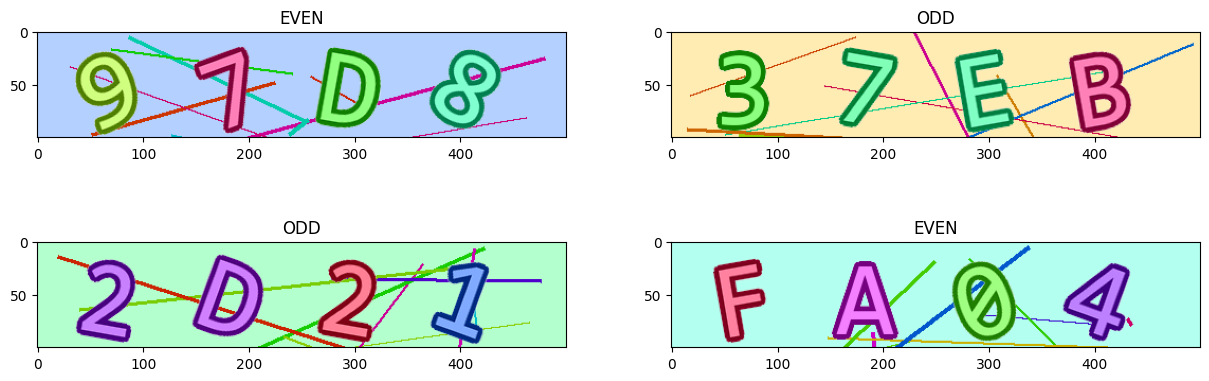

In [9]:
train_batch,train_label = next(iter(train_dataloader))

# visualization:
rows = 2
cols = 2
n = rows*cols
#torch.manual_seed(42)
rand_idx = torch.randint(0,len(train_batch),size=[n])
disp_image = train_batch[rand_idx]
disp_label = train_label[rand_idx]

plt.figure(figsize=[15,5])
for i in range(n):
    plt.subplot(rows,cols,i+1)
    image = tensor2image(disp_image[i])
    plt.imshow(image)
    plt.title(class_dict[disp_label[i].item()])

## Model:
### ResNet_18:

In [10]:
from torch import nn 


class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x 
    
    
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

### Device setup:


In [11]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

### model setup:

In [12]:
model = ResNet_18(image_channels=4,num_classes=1).to(device)

In [13]:
from torchsummary import summary
print(summary(model,input_size=train_data[0][0].shape,batch_size=32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 64, 50, 250]          12,608
       BatchNorm2d-2          [32, 64, 50, 250]             128
              ReLU-3          [32, 64, 50, 250]               0
         MaxPool2d-4          [32, 64, 25, 125]               0
            Conv2d-5          [32, 64, 25, 125]          36,928
       BatchNorm2d-6          [32, 64, 25, 125]             128
              ReLU-7          [32, 64, 25, 125]               0
            Conv2d-8          [32, 64, 25, 125]          36,928
       BatchNorm2d-9          [32, 64, 25, 125]             128
             ReLU-10          [32, 64, 25, 125]               0
            Block-11          [32, 64, 25, 125]               0
           Conv2d-12          [32, 64, 25, 125]          36,928
      BatchNorm2d-13          [32, 64, 25, 125]             128
             ReLU-14          [32, 64, 

In [14]:
# loss :
loss_fn = nn.BCEWithLogitsLoss()
#optimizer :
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)
#accuracy:
from sklearn.metrics import accuracy_score

## Training and Testing:

In [15]:
# total epoch:
train_loss = []
test_loss = []

train_acc = []
test_acc = []

# batch:
train_batch = []
test_batch = []

In [16]:
def train_step(model,dataloader,loss_fn,optimizer,accuracy_fn,device):
    
    
    # loss and accuracy:
    total_loss,total_acc = 0,0
    
    # train mode:
    model.train()
    
    i = 0
    # Train loop:
    for X,y in tqdm(dataloader):
        #if i % 10 == 0:
            #print(f"Batch no---> {i}")
        
        #i+=1
        # copy to device
        X = X.to(device)
        y = y.to(device)
        
        # forward pass:
        y_pred = model(X)
        train_pred = torch.round(nn.Sigmoid()(y_pred))
        
        # loss calculation:
        loss = loss_fn(y_pred.squeeze(),y)
        total_loss += loss
        
        # accuracy calculation:
        total_acc+= accuracy_fn(y.cpu(),train_pred.cpu().detach().numpy())
        
        # optimizer zero_grad:
        optimizer.zero_grad()
        
        # loss backward:
        loss.backward()
        
        # optimizer step:
        optimizer.step()
        
        
    total_loss /= len(dataloader)
    total_acc /= len(dataloader)
    
    #train_loss collection:
    train_loss.append(total_loss.item())
    train_acc.append(total_acc)
    
    print(f"Training | loss : {total_loss} | accuracy : {total_acc} |")

In [17]:
def test_step(model,dataloader,loss_fn,accuracy_fn,device):
    
    # loss and accuracy:
    total_loss,total_acc = 0,0
    
    # train mode:
    model.eval()
    
    i = 0
    # Train loop:
    with torch.inference_mode():
        for X,y in tqdm(dataloader):
            #if i % 5 == 0:
                #print(f"Batch no---> {i}")
        
            #i+=1
            
            # copy to device
            X = X.to(device)
            y = y.to(device)

            # forward pass:
            y_pred = model(X)
            train_pred = torch.round(nn.Sigmoid()(y_pred))
            
            # loss calculation:
            loss = loss_fn(y_pred.squeeze(),y)
            total_loss += loss

            # accuracy calculation:
            total_acc+= accuracy_fn(y.cpu(),train_pred.cpu().detach().numpy())


        total_loss /= len(dataloader)
        total_acc /= len(dataloader)
        
        #train_loss collection:
        test_loss.append(total_loss.cpu())
        test_acc.append(total_acc)
        
    print(f"Testing | loss : {total_loss} | accuracy : {total_acc} |")

## Evaluation:

In [18]:
from tqdm.notebook import tqdm
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 7

start = time.perf_counter()
for epoch in tqdm(range(epochs)):
    print(f"Epoch.....{epoch}")
    print()
    print("Training")
    train_step(model,train_dataloader,loss_fn,optimizer,accuracy_score,device)
    print("Testing")
    test_step(model,test_dataloader,loss_fn,accuracy_score,device)
    print()
    
stop = time.perf_counter()

model_time = stop-start
print()
print(f"{model.__class__.__name__} has taken {model_time}")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch.....0

Training


  0%|          | 0/57 [00:00<?, ?it/s]

Training | loss : 0.7381831051206175 | accuracy : 0.49506578947368424 |
Testing


  0%|          | 0/7 [00:00<?, ?it/s]

Testing | loss : 0.7130646686668375 | accuracy : 0.49107142857142855 |

Epoch.....1

Training


  0%|          | 0/57 [00:00<?, ?it/s]

Training | loss : 0.6824402339652328 | accuracy : 0.5663377192982456 |
Testing


  0%|          | 0/7 [00:00<?, ?it/s]

Testing | loss : 0.6339478140913083 | accuracy : 0.6875 |

Epoch.....2

Training


  0%|          | 0/57 [00:00<?, ?it/s]

Training | loss : 0.564138417719126 | accuracy : 0.6918859649122807 |
Testing


  0%|          | 0/7 [00:00<?, ?it/s]

Testing | loss : 1.02777895129319 | accuracy : 0.5357142857142857 |

Epoch.....3

Training


  0%|          | 0/57 [00:00<?, ?it/s]

Training | loss : 0.12893207815990965 | accuracy : 0.9599780701754386 |
Testing


  0%|          | 0/7 [00:00<?, ?it/s]

Testing | loss : 0.20046046596478714 | accuracy : 0.9196428571428571 |

Epoch.....4

Training


  0%|          | 0/57 [00:00<?, ?it/s]

Training | loss : 0.04437433815442111 | accuracy : 0.9895833333333334 |
Testing


  0%|          | 0/7 [00:00<?, ?it/s]

Testing | loss : 0.15258644945286903 | accuracy : 0.9375 |

Epoch.....5

Training


  0%|          | 0/57 [00:00<?, ?it/s]

Training | loss : 0.029946397563665676 | accuracy : 0.9923245614035088 |
Testing


  0%|          | 0/7 [00:00<?, ?it/s]

Testing | loss : 0.005676608471860942 | accuracy : 1.0 |

Epoch.....6

Training


  0%|          | 0/57 [00:00<?, ?it/s]

Training | loss : 0.003681510808247056 | accuracy : 1.0 |
Testing


  0%|          | 0/7 [00:00<?, ?it/s]

Testing | loss : 0.00136415353339154 | accuracy : 1.0 |


ResNet_18 has taken 98.7483096


## Visualization:

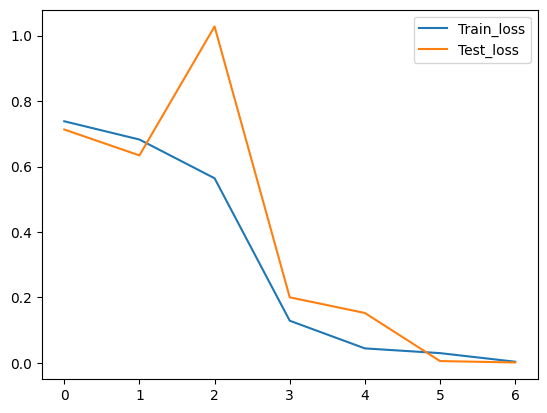

In [19]:
plt.plot(range(len(train_loss)),train_loss,label= "Train_loss")
plt.plot(range(len(test_loss)),test_loss,label = "Test_loss")
plt.legend()

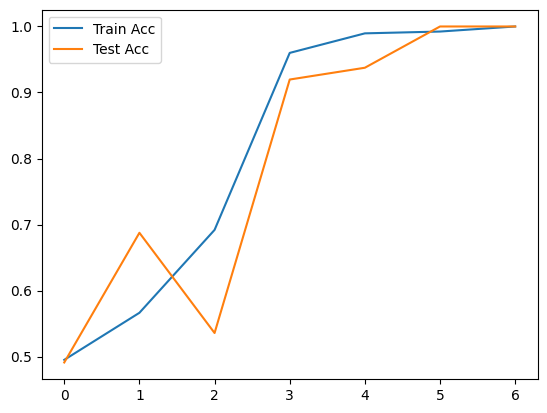

In [20]:
plt.plot(range(len(train_acc)),train_acc,label = "Train Acc")
plt.plot(range(len(test_acc)),test_acc,label = "Test Acc")
plt.legend() 

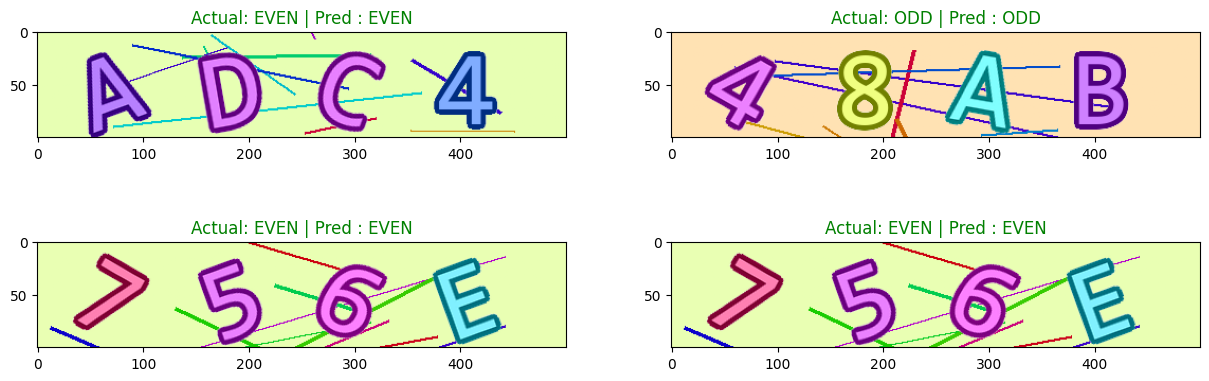

In [21]:
# visualization:
rows = 2
cols = 2
n = rows*cols
#torch.manual_seed(42)
rand_idx = torch.randint(0,32,size=[n])


plt.figure(figsize=[15,5])
for i in range(n):
    disp_image,disp_label = test_data[rand_idx[i].item()]
    plt.subplot(rows,cols,i+1)
    image = tensor2image(disp_image)
    plt.imshow(image)
    
    # prediction:
    model.eval()
    with torch.inference_mode():
        y_pred = model(disp_image.unsqueeze(dim=0).to(device)).cpu()
        pred_label = torch.round(nn.Sigmoid()(y_pred)).item()
    
    if disp_label != pred_label:
        title = plt.title(f"Actual: {class_dict[disp_label]} | Pred : {class_dict[pred_label]}")
        title.set_color('red')
    else:
        title = plt.title(f"Actual: {class_dict[disp_label]} | Pred : {class_dict[pred_label]}")
        title.set_color('green')

### load model:

In [22]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True,exist_ok=True)

model_name = "ResNet_18.pth"
save_path = model_path/model_name

torch.save(model.state_dict(),f=save_path)